In [16]:
from typing import Union, Self
from numbers import Number
from itertools import chain, product

import numpy as np
import sympy as sp
import cvxpy as cp

import scipy
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
from scipy.linalg import qr
from scipy.sparse import coo_matrix, csc_matrix
from scipy.sparse.linalg import splu, svds
from sksparse.cholmod import cholesky

from bmn.algebra import MatrixOperator, SingleTraceOperator, MatrixSystem
from bmn.linear_algebra import get_null_space, create_sparse_matrix_from_dict, is_in_row_space, get_row_space
from bmn.bootstrap import BootstrapSystem
from bmn.solver import minimal_eigval, sdp_init, sdp_relax, sdp_minimize, minimize, get_quadratic_constraint_vector

np.set_printoptions(linewidth=120)  # Adjust the number to the desired width

# plot settings
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['lines.linewidth'] = 2
plt.rc('font', family='serif',size=16)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)
matplotlib.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
    )
matplotlib.rcParams.update(
    {"axes.grid":True,
    "grid.alpha":0.75,
    "grid.linewidth":0.5}
    )
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## One Matrix Model

In [2]:
matrix_system = MatrixSystem(
    #operator_basis=['X', 'P'],
    operator_basis=['X', 'Pi'],
    commutation_rules_concise = {
        #('P', 'X'): -1j,
        ('Pi', 'X'): 1, # use Pi' = i P to ensure reality
    },
    #hermitian_dict={'P': True, 'X': True},
    hermitian_dict={'Pi': False, 'X': True},
)

# scale variables as P = sqrt(N) P', X = sqrt(N) X'
hamiltonian = SingleTraceOperator(
        #data={("P", "P"): 1, ("X", "X"): 1, ("X", "X", "X", "X"): 7}
        data={("Pi", "Pi"): -1, ("X", "X"): 1, ("X", "X", "X", "X"): 1e-4}
    )

# <tr G O > = 0 might need to be applied only for O with deg <= L-2
#gauge = MatrixOperator(data={('X', 'P'): 1j, ('P', 'X'): -1j, ():1})
gauge = MatrixOperator(data={('X', 'Pi'): 1, ('Pi', 'X'): -1, ():1})

bootstrap = BootstrapSystem(
    matrix_system=matrix_system,
    hamiltonian=hamiltonian,
    gauge=gauge,
    half_max_degree=3,
    odd_degree_vanish=False
)

Assuming all operators are either Hermitian or anti-Hermitna.


In [3]:
param_optimized = minimize(
    bootstrap=bootstrap,
    op=bootstrap.hamiltonian,
    #init=10 * np.random.normal(size=bootstrap.param_dim_null),
    #maxiters=100,
    #eps=5e-1,
    #reg=5e-5,
)

generated 33 Hamiltonian constraints
generated 31 gauge constraints
generated 105 reality constraints
Null matrix has not been computed yet. Building it by solving the linear constraints.
generated 33 Hamiltonian constraints
generated 31 gauge constraints
generated 105 reality constraints
constraint 0 corresponds to operator_idx 4, op = ('X', 'Pi')
constraint 1 corresponds to operator_idx 5, op = ('Pi', 'X')
constraint 2 corresponds to operator_idx 8, op = ('X', 'X', 'Pi')
constraint 3 corresponds to operator_idx 9, op = ('X', 'Pi', 'X')
constraint 4 corresponds to operator_idx 11, op = ('Pi', 'X', 'X')
constraint 5 corresponds to operator_idx 16, op = ('X', 'X', 'X', 'Pi')
constraint from operator_idx = 17 is quadratically trivial.
constraint 6 corresponds to operator_idx 18, op = ('X', 'X', 'Pi', 'Pi')
constraint 7 corresponds to operator_idx 19, op = ('X', 'Pi', 'X', 'X')
constraint 8 corresponds to operator_idx 21, op = ('X', 'Pi', 'Pi', 'X')
constraint 9 corresponds to operator_id

In [4]:
cyclic_constraints = bootstrap.generate_cyclic_constraints()

# check the quadratically-trivial quadratic constraints
vec = bootstrap.single_trace_to_coefficient_vector(
    st_operator=cyclic_constraints[17]['lhs'],
    return_null_basis=True
    )
vec.dot(param_optimized)

3.554303848321366e-05

In [5]:
# check the quadratically-trivial quadratic constraints
vec = bootstrap.single_trace_to_coefficient_vector(
    st_operator=cyclic_constraints[28]['lhs'],
    return_null_basis=True
    )
vec.dot(param_optimized)

3.5552802811029495e-05

In [6]:
bootstrap_array_sparse = bootstrap.build_bootstrap_table()
minimal_eigval(bootstrap_array_sparse=bootstrap_array_sparse, parameter_vector_null=param_optimized)

-5.115026168970681e-05

In [7]:
op = bootstrap.hamiltonian
vec = bootstrap.single_trace_to_coefficient_vector(op, return_null_basis=True)
vec.dot(param_optimized)

0.9998958242073677

In [8]:
op = SingleTraceOperator(
        data={("X", "X"): 1}
    )
vec = bootstrap.single_trace_to_coefficient_vector(op, return_null_basis=True)
vec.dot(param_optimized)

0.499872905779164

In [ ]:
op = SingleTraceOperator(
        data={("X", "X", "X", "X"): 1}
    )
vec = bootstrap.single_trace_to_coefficient_vector(op, return_null_basis=True)
vec.dot(param_optimized)

## Scan

In [35]:
g_values = np.linspace(0.1, 4, 12)

results = {
    'g': g_values,
    'param': [],
    'energy': [],
    'x^2': [],
    }

for g in g_values:

    matrix_system = MatrixSystem(
        #operator_basis=['X', 'P'],
        operator_basis=['X', 'Pi'],
        commutation_rules_concise = {
            #('P', 'X'): -1j,
            ('Pi', 'X'): 1, # use Pi' = i P to ensure reality
        },
        #hermitian_dict={'P': True, 'X': True},
        hermitian_dict={'Pi': False, 'X': True},
    )

    # scale variables as P = sqrt(N) P', X = sqrt(N) X'
    hamiltonian = SingleTraceOperator(
            #data={("P", "P"): 1, ("X", "X"): 1, ("X", "X", "X", "X"): 7}
            data={("Pi", "Pi"): -1, ("X", "X"): 1, ("X", "X", "X", "X"): g}
        )

    # <tr G O > = 0 might need to be applied only for O with deg <= L-2
    #gauge = MatrixOperator(data={('X', 'P'): 1j, ('P', 'X'): -1j, ():1})
    gauge = MatrixOperator(data={('X', 'Pi'): 1, ('Pi', 'X'): -1, ():1})

    bootstrap = BootstrapSystem(
        matrix_system=matrix_system,
        hamiltonian=hamiltonian,
        gauge=gauge,
        half_max_degree=2,
        odd_degree_vanish=True
    )

    param_optimized = minimize(
        bootstrap=bootstrap,
        op=bootstrap.hamiltonian,
        )

    op = bootstrap.hamiltonian
    vec = bootstrap.single_trace_to_coefficient_vector(op, return_null_basis=True)
    energy = vec.dot(param_optimized)

    op = SingleTraceOperator(
        data={("X", "X"): 1}
        )
    vec = bootstrap.single_trace_to_coefficient_vector(op, return_null_basis=True)
    x2 = vec.dot(param_optimized)

    results['param'].append(param_optimized)
    results['energy'].append(energy)
    results['x^2'].append(x2)

Assuming all operators are either Hermitian or anti-Hermitna.
generated 9 Hamiltonian constraints
generated 7 gauge constraints
generated 21 reality constraints
generated 10 odd degree vanish constraints
Null matrix has not been computed yet. Building it by solving the linear constraints.
generated 9 Hamiltonian constraints
generated 7 gauge constraints
generated 21 reality constraints
generated 10 odd degree vanish constraints
constraint 0 corresponds to operator_idx 4, op = ('X', 'Pi')
constraint 1 corresponds to operator_idx 5, op = ('Pi', 'X')
constraint 2 corresponds to operator_idx 16, op = ('X', 'X', 'X', 'Pi')
constraint from operator_idx = 17 is quadratically trivial.
constraint 3 corresponds to operator_idx 18, op = ('X', 'X', 'Pi', 'Pi')
constraint 4 corresponds to operator_idx 19, op = ('X', 'Pi', 'X', 'X')
constraint 5 corresponds to operator_idx 21, op = ('X', 'Pi', 'Pi', 'X')
constraint 6 corresponds to operator_idx 22, op = ('X', 'Pi', 'Pi', 'Pi')
constraint 7 correspon

/Users/gavinhartnett/miniconda3/envs/bmnsim/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 9, constraints m: 50
cones: 	  z: primal zero / dual free vars: 13
	  q: soc vars: 9, qsize: 1
	  s: psd vars: 28, ssize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 10000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 199, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.37e+00  9.34e-01  4.96e+00 -8.89e-01  1.00e-01  6.84e-04 
   250| 6.10e-01  5.30e-02  1.65e-04  1.11e+00  3.13e-02  1.90e-03 
   

In [36]:
results['energy']

[1.0351540516814484,
 1.062466272034663,
 1.1981085553207698,
 1.2508441197401856,
 1.3109552948656542,
 1.360463441349434,
 1.4124404995151008,
 1.643144410432471,
 2.0906694069079577,
 1.768521472774938,
 1.5609804611013776,
 1.5757164444632576]

In [37]:
results['g']

array([0.1       , 0.45454545, 0.80909091, 1.16363636, 1.51818182, 1.87272727, 2.22727273, 2.58181818, 2.93636364,
       3.29090909, 3.64545455, 4.        ])

Next
- why does it not match the paper - not converging!
- how to get exact curve?

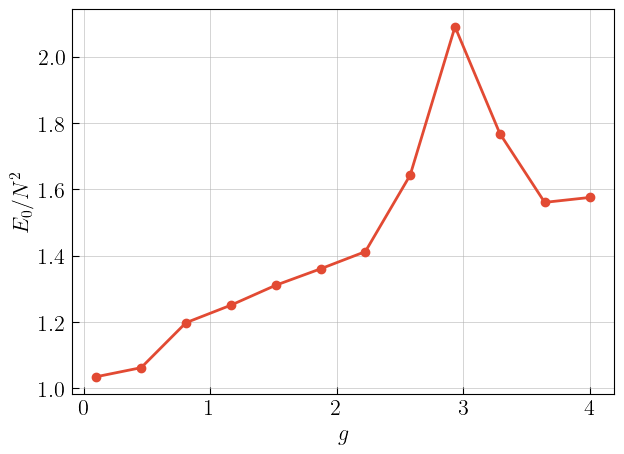

In [38]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(results['g'], results['energy'], '-o')
ax.set_xlabel(r"$g$")
ax.set_ylabel(r"$E_0/N^2$")
plt.show()

## OLD

In [ ]:
nu = 1.0

matrix_system = MatrixSystem(
    operator_basis=['X0', 'X1', 'X2', 'P0', 'P1', 'P2'],
    commutation_rules_concise = {
        ('P0', 'X0'): -1j,
        ('P1', 'X1'): -1j,
        ('P2', 'X2'): -1j,
    }
)

# scale variables as P = sqrt(N) P', X = sqrt(N) X'
hamiltonian = SingleTraceOperator(
        data={
           # kinetic term
            ("P0", "P1"): 1,
            ("P1", "P1"): 1,
            ("P1", "P1"): 1,
            # quadratic term
            ('X0', 'X0'): nu**2 / 2,
            ('X1', 'X1'): nu**2 / 2,
            ('X2', 'X2'): nu**2 / 2,
            # cubic term
            ('X0', 'X1', 'X2'): 6 * 1j * nu,
            # quadratic term (XY)
            ('X0', 'X1', 'X0', 'X1'): - 1/4,
            ('X1', 'X0', 'X1', 'X0'): -1/4,
            ('X0', 'X1', 'X1', 'X0'): 1/4,
            ('X1', 'X0', 'X0', 'X1'): 1/4,
            # quadratic term (XZ) TODO check sign
            ('X0', 'X2', 'X0', 'X2'): - 1/4,
            ('X2', 'X0', 'X2', 'X0'): -1/4,
            ('X0', 'X2', 'X2', 'X0'): 1/4,
            ('X2', 'X0', 'X0', 'X2'): 1/4,
            # quadratic term (YZ)
            ('X1', 'X2', 'X1', 'X2'): - 1/4,
            ('X2', 'X1', 'X2', 'X1'): -1/4,
            ('X1', 'X2', 'X2', 'X1'): 1/4,
            ('X2', 'X1', 'X1', 'X2'): 1/4,
            }
            )

# <tr G O > = 0 might need to be applied only for O with deg <= L-2
gauge = MatrixOperator(
    data={
        ('X0', 'P0'): 1j,
        ('P0', 'X0'): -1j,
        ('X1', 'P1'): 1j,
        ('P1', 'X1'): -1j,
        ('X2', 'P2'): 1j,
        ('P2', 'X2'): -1j,
        ():1}
    )

bootstrap = BootstrapSystem(
    matrix_system=matrix_system,
    hamiltonian=hamiltonian,
    gauge=gauge,
    half_max_degree=2
)
#bootstrap.operator_list[:bootstrap.psd_matrix_dim]
bootstrap.matrix_system.commutation_rules

In [ ]:
bootstrap.build_linear_constraints()